In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


## Model training
### Tree based models
* XGB, LGBM, RF, ETC, DT

### Neural Networks
* NN, autoencoders(?), GNN


## Model Evaluation

### Get Shap for model explanability both local and global
* Tune model on best model selected (either on precision/f1/recall and feature blend)

### Test model on out of sample set
* Get metrics(acc,precision,f1, etc..) from out of sample set

## Selection of Best Model

### Dashboard(?) --enhancement
* Transfer results to a dashboard

# Import file here

In [4]:
# Load Data
#df = pd.read_csv("twitter_human_bots_dataset.csv")
df = pd.read_csv("source data/twitter_human_bots_dataset.csv", index_col=0)



## Process data

#### Deviation from humans average tweets per day

This has to be processed after train test split.

In [ ]:
# humans_mean = df[df['account_type'] == 'human']['average_tweets_per_day'].mean()
# humans_std = df[df['account_type'] == 'human']['average_tweets_per_day'].std()

# df['deviation_from_humans'] = df['average_tweets_per_day'].apply(
#     lambda x: (x - humans_mean) / humans_std
# )

# df['deviation_from_humans'].describe()

In [5]:

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Calculate Account Age
current_time = datetime.now()
df['account_age_days'] = (current_time - df['created_at']).dt.days

# Time-Based Features
df['creation_hour'] = df['created_at'].dt.hour
df['creation_day_of_week'] = df['created_at'].dt.dayofweek
df['creation_month'] = df['created_at'].dt.month
df['creation_year'] = df['created_at'].dt.year
df['creation_quarter'] = df['created_at'].dt.quarter
df['is_weekend'] = df['creation_day_of_week'] >= 5
df['creation_week_of_year'] = df['created_at'].dt.isocalendar().week
df['is_beginning_of_month'] = df['created_at'].dt.day <= 5
df['is_end_of_month'] = df['created_at'].dt.day >= 26

# Define part of day based on hour
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['creation_hour'].apply(part_of_day)

# Additional Features
humans_mean = df[df['account_type'] == 'human']['average_tweets_per_day'].mean()
humans_std = df[df['account_type'] == 'human']['average_tweets_per_day'].std()
df['deviation_from_humans'] = (df['average_tweets_per_day'] - humans_mean) / humans_std

# Description Length Feature
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Followers/Friends Ratios
df['followers_to_friends_ratio'] = df['followers_count'] / df['friends_count']
df['followers_to_friends_ratio'].fillna(0, inplace=True)

# Followers to Tweets Per Day Ratio
df['followers_to_tweets_per_day_ratio'] = df['followers_count'] / df['average_tweets_per_day']
df['followers_to_tweets_per_day_ratio'].fillna(0, inplace=True)

# Mentions Count in Description
import re

def extract_mentions(description):
    return re.findall(r'@\w+', str(description))

df['mentions'] = df['description'].apply(extract_mentions)
df['mention_count'] = df['mentions'].apply(len)

# Ensure any remaining NaN values are filled if necessary
########################################################################
# TO DISCUSS METHOD OF IMPUTATION
########################################################################
df.fillna(0, inplace=True)
df.replace(np.inf,0, inplace = True)

# ENCODING METHOD FOR LANG AND LOCATION TO BE DISCUSSSED

In [6]:
# Encoding Categorical Features
df['account_type'] = df['account_type'].map({'human': 0, 'bot': 1})

encode_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'lang', 'location', 'verified',
               'creation_year', 'is_weekend', 'is_beginning_of_month', 'is_end_of_month', 'part_of_day']

label_encoder = LabelEncoder()
for col in encode_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs if any


# Define Feature Columns and Target
id_col = ['id']
labels = ['account_type']
predictive_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count','account_type']



In [7]:
# Set cutoff date for training/validation split
cutoff_date = pd.to_datetime('2017-01-01')
df['date'] = pd.to_datetime(df['created_at'])

# Define columns to keep
id_cols = ['id']
target_cols = ['account_type']
# Assuming predictive_cols is already defined
columns_to_keep = id_cols + predictive_cols

# Filter columns before splitting
df_filtered = df[columns_to_keep + ['date']]

# Split data based on cutoff date
oot = df_filtered[df_filtered['date'] >= cutoff_date].set_index('id')
df_model = df_filtered[df_filtered['date'] < cutoff_date].set_index('id')

# Drop date column as it's no longer needed
oot = oot.drop('date', axis=1)
df_model = df_model.drop('date', axis=1)

# Train, Test, Validation Splits
RANDOM_SEED = 2024
train, test = train_test_split(df_model, test_size=0.2, random_state=RANDOM_SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

# Add 'X_fold' columns for each split
train['X_fold'] = 'train'
test['X_fold'] = 'test'
valid['X_fold'] = 'valid'
oot['X_fold'] = 'oot'

# Combine all datasets for modeling
mds = pd.concat([train, test, valid, oot]).copy(deep=True)
mds = mds.reset_index()

In [6]:
import itertools
import math
from hyperopt import hp
import xgboost as xgb
import lightgbm as lgb
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.model_selection import train_test_split
import warnings



import os

# Supervised Models Pipeline
- Random Forest
- XGBoost
- LGBM
- Logistic Regression

In [119]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import KFold, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json
from functools import partial
import warnings
warnings.filterwarnings("ignore")

class UnifiedModelTrainer:
    def __init__(self, random_state=2024):
        self.random_state = random_state
    
    ######################
    ## Data Preparation ##
    ######################
    
    def prepare_data(self, df, features, target):
        """Prepare train, validation, test and out-of-time datasets"""
        train_valid = df[df['X_fold'].isin(['train', 'valid'])]
        test = df[df['X_fold'] == 'test']
        oot = df[df['X_fold'] == 'oot']
        
        X_train_valid = train_valid[features]
        y_train_valid = train_valid[target]
        
        X_test = test[features]
        y_test = test[target]
        
        X_oot = oot[features]
        y_oot = oot[target]
        
        return (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot)

    ##############################
    ## Evaluation Model Metrics ##
    ##############################
    def evaluate_model(self, model, X_test, y_test, X_oot, y_oot):
        """Evaluate model performance on test and OOT datasets"""
        if isinstance(model, lgb.Booster) or isinstance(model, RandomForestClassifier):
            pred_test = model.predict(X_test)
            pred_oot = model.predict(X_oot)
    
        else:
            pred_test = model.predict_proba(X_test)[:, 1]
            pred_oot = model.predict_proba(X_oot)[:, 1]
        
        metrics = {}
        metrics['test_auc'] = roc_auc_score(y_test, pred_test)
        metrics['oot_auc'] = roc_auc_score(y_oot, pred_oot)
        #metrics['recall'] = recall_score(y_test, pred_test)
        
        # Calculate additional metrics for different thresholds
        threshold_metrics = {}
        for threshold in [0.5, 0.8, 0.85, 0.9, 0.95]:
            pred_test_binary = (pred_test > threshold).astype(int)
            pred_oot_binary = (pred_oot > threshold).astype(int)
            
            threshold_metrics[f'threshold_{threshold}'] = {
                'test': {
                    'precision': precision_score(y_test, pred_test_binary),
                    'recall': recall_score(y_test, pred_test_binary),
                    'f1': f1_score(y_test, pred_test_binary),
                    'auc': roc_auc_score(y_test, pred_test_binary)
                },
                'oot': {
                    'precision': precision_score(y_oot, pred_oot_binary),
                    'recall': recall_score(y_oot, pred_oot_binary),
                    'f1': f1_score(y_oot, pred_oot_binary),
                    'auc': roc_auc_score(y_oot, pred_oot_binary)

                }
            }
        
        metrics['threshold_metrics'] = threshold_metrics
        return metrics
        
    ############################
    ## Hyperparameter Tunning ##
    ############################
    def create_search_space(self, model_type):
        """Define complete search space including data preparation and model parameters."""
        
        # Common parameters
        common_params = {
            'k_folds': hp.choice('k_folds', [3, 5, 7, 10]),
            'k_split': hp.choice('k_split', ['non_ts', 'ts']),
            
            # Feature selection parameters
            'f_method': hp.choice('f_method', [
                'all',  # Use all features
                'kbest_f',  # SelectKBest with f_classif
                'kbest_mi',  # SelectKBest with mutual_info_classif
                'l1',  # L1-based feature selection
                'tree_importance'  # Tree-based feature importance
            ]),
            'num_feats': hp.choice('num_feats', [20, 30, 40, 50, 'all']),
            
            # Scaling parameters
            'scaler': hp.choice('scaler', [
                'noscaler',
                'standard',
                'minmax',
                'robust'
            ]),
            
            # Fixed parameters
            'SEED': self.random_state
        }
        
        if model_type == 'lgbm':
            # LightGBM specific parameters
            lgbm_params = {
                'num_leaves': hp.quniform('num_leaves', 15, 127, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.9),
                'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
                'bagging_freq': hp.quniform('bagging_freq', 2, 10, 1),
                'min_child_samples': hp.quniform('min_child_samples', 10, 150, 1),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **lgbm_params}

        elif model_type == 'xgb':
            # XGBoost specific parameters
            xgb_params = {
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'subsample': hp.uniform('subsample', 0.6, 1.0),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
                'min_child_weight': hp.quniform('min_child_weight', 1, 7, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **xgb_params}
        
        elif model_type == 'rf':
            rf_params = {
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
            }
            return {**common_params, **rf_params}
        
        else:
            raise ValueError("Invalid model type. Please choose 'lgbm' or 'xgb'.")

    
    def apply_feature_selection(self, X, y, method, num_feats):
        """Apply feature selection based on specified method"""
        if method == 'all' or num_feats == 'all':
            return X
            
        n_features = min(num_feats, X.shape[1])
        
        if method == 'kbest_f':
            selector = SelectKBest(score_func=f_classif, k=n_features)
        elif method == 'kbest_mi':
            selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
        elif method == 'l1':
            from sklearn.linear_model import LogisticRegression
            selector = LogisticRegression(penalty='l1', solver='saga', random_state=self.random_state)
            selector.fit(X, y)
            mask = np.abs(selector.coef_[0]) > 0
            return X.iloc[:, mask]
        elif method == 'tree_importance':
            model = lgb.LGBMClassifier(random_state=self.random_state)
            model.fit(X, y)
            importance = pd.Series(model.feature_importances_, index=X.columns)
            selected_features = importance.nlargest(n_features).index
            return X[selected_features]
            
        if method in ['kbest_f', 'kbest_mi']:
            selector.fit(X, y)
            mask = selector.get_support()
            return X.iloc[:, mask]
            
        return X
    
    def plot_results(self, metrics, output_dir):
        """Create and save visualization of results"""
        # Plot threshold performance
        plt.figure(figsize=(12, 6))
        thresholds = sorted(metrics['threshold_metrics'].keys(), 
                          key=lambda x: float(x.split('_')[1]))
        
        test_precision = [metrics['threshold_metrics'][t]['test']['precision'] 
                         for t in thresholds]
        oot_precision = [metrics['threshold_metrics'][t]['oot']['precision'] 
                        for t in thresholds]
        
        plt.plot(thresholds, test_precision, label='Test Precision')
        plt.plot(thresholds, oot_precision, label='OOT Precision')
        plt.xlabel('Threshold')
        plt.ylabel('Precision')
        plt.title('Model Performance Across Thresholds')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/threshold_performance.png")
        plt.close()
    
    def apply_scaling(self, X_train, X_test, X_oot, scaler_type):
        """Apply scaling transformation to the data"""
        if scaler_type == 'noscaler':
            return X_train, X_test, X_oot
            
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'robust':
            scaler = RobustScaler()
            
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        X_oot_scaled = pd.DataFrame(
            scaler.transform(X_oot),
            columns=X_oot.columns,
            index=X_oot.index
        )
        
        return X_train_scaled, X_test_scaled, X_oot_scaled
    
    def get_cv_splitter(self, k_split, k_folds):
        """Get cross-validation splitter based on specified method"""
        if k_split == 'non_ts':
            return KFold(n_splits=k_folds, shuffle=True, random_state=self.random_state)
        else:
            return TimeSeriesSplit(n_splits=k_folds)

###########################################
## Objective Functions for LGBM, XGB, RF ##
###########################################

    def objective_lgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for LightGBM optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare LightGBM parameters
            params = {
                'objective': 'binary',
                'metric': 'auc',#auc
                'boosting_type': 'gbdt',
                'num_leaves': int(space['num_leaves']),
                'learning_rate': space['learning_rate'],
                'feature_fraction': space['feature_fraction'],
                'bagging_fraction': space['bagging_fraction'],
                'bagging_freq': int(space['bagging_freq']),
                'min_child_samples': int(space['min_child_samples']),
                'max_depth': int(space['max_depth']),
                'n_estimators': int(space['n_estimators']),
                'verbose': -1,
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
                valid_data = lgb.Dataset(X_fold_valid, label=y_fold_valid, reference=train_data)
                
                model = lgb.train(
                    params,
                    train_data,
                    valid_sets=[valid_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=20)]
                )
                
                pred_valid = model.predict(X_fold_valid)
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid)) # modify metric here for tuning for other metrics
            
            # Train final model on full training data
            train_data = lgb.Dataset(X_train_processed, label=y_train)
            valid_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)
            
            final_model = lgb.train(
                params,
                train_data,
                valid_sets=[valid_data],
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
            )
            
            # Calculate metrics
            metrics = self.evaluate_model(
                final_model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': final_model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    def objective_xgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for XGBoost optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare XGBoost parameters
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'max_depth': int(space['max_depth']),
                'learning_rate': space['learning_rate'],
                'subsample': space['subsample'],
                'colsample_bytree': space['colsample_bytree'],
                'min_child_weight': int(space['min_child_weight']),
                'n_estimators': int(space['n_estimators']),
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_valid, y_fold_valid)], 
                        verbose=False)
                
                pred_valid = model.predict_proba(X_fold_valid)[:, 1]
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid))
            
            # Train final model on full training data
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_processed, y_train, eval_set=[(X_test_processed, y_test)], 
                     verbose=False)
            
            # Calculate metrics
            metrics = self.evaluate_model(
                model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}

    def objective_rf(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Objective function for RandomForestClassifier"""
        try:
            # Feature selection and scaling
            X_train_selected = self.apply_feature_selection(X_train, y_train, space['f_method'], space['num_feats'])
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            X_train_scaled, X_test_scaled, X_oot_scaled = self.apply_scaling(X_train_selected, X_test_selected, X_oot_selected, space['scaler'])

            # Set parameters for RandomForestClassifier
            params = {
                'n_estimators': int(space['n_estimators']),
                'max_depth': int(space['max_depth']),
                'min_samples_split': int(space['min_samples_split']),
                'min_samples_leaf': int(space['min_samples_leaf']),
                'random_state': self.random_state
            }
            
            model = RandomForestClassifier(**params)
            model.fit(X_train_scaled, y_train)
            metrics = self.evaluate_model(model, X_test_scaled, y_test, X_oot_scaled, y_oot)
            
            return {'loss': -metrics['test_auc'], 
                    'model': model, 
                    'status': STATUS_OK, 
                    'metrics': metrics,
                    'params': params,
                    'feature_columns': list(X_train_selected.columns)}

        except Exception as e:
            print(f"RandomForest Error: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    #########################
    ## Logistic Regression ##
    #########################
    def run_logistic_regression(self, df, features, target):

        # Prepare the data using the prepare_data method
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(df, features, target)
        
        # Initialize and fit the logistic regression model
        log_reg = LogisticRegression()
        log_reg.fit(X_train_valid, y_train_valid)
        
        # Make predictions on the test set
        y_pred_prob = log_reg.predict_proba(X_test)[:,1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate accuracy, confusion matrix, and classification report
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Print results
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)
        
        # Store metrics in a dictionary for further use
        metrics = {
            "accuracy": accuracy,
            "confusion_matrix": conf_matrix,
            "classification_report": class_report
        }
        
        return log_reg, metrics

    def optimize_model(self, df, features, target, max_evals=20, model_type = ""):
        """Run complete model optimization pipeline with enhanced search space"""
        # Prepare data
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(
            df, features, target
        )
        if model_type == 'lgbm':
        # Define objective function with prepared data
            objective = partial(
                self.objective_lgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'xgb':
            objective = partial(
                self.objective_xgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'rf':
            objective = partial(
                self.objective_rf,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        # Run optimization
        trials = Trials()
        best = fmin(
            fn=objective,
            space=self.create_search_space(model_type),
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials
        )
        
        # Get best trial
        best_trial = sorted(trials.trials, key=lambda x: x['result']['loss'])[0]
        
        # Store trials history
        self.trials_history = pd.DataFrame([
            {
                **trial['misc']['vals'],
                'cv_score': -trial['result']['loss'],
                'test_auc': trial['result']['metrics']['test_auc'],
                'oot_auc': trial['result']['metrics']['oot_auc'],
                **{
                    f"threshold_{threshold}_{metric}_{set_type}": trial['result']['metrics']['threshold_metrics'][f'threshold_{threshold}'][set_type][metric]
                    for threshold in [0.5,0.8, 0.85, 0.9, 0.95]
                    for set_type in ['test', 'oot']
                    for metric in ['precision', 'recall', 'f1', 'auc']
                }
            }
            for trial in trials.trials
            if 'loss' in trial['result']
        ])
        
        return (
            
            best_trial['result']['model'],
            best_trial['result']['metrics'],
            best_trial['result']['params'],
            best_trial['result']['feature_columns']
            
         )
    
    
    def save_model(self, model, output_dir, model_type, model_name='_best_model.pkl'):
        """Save the trained XGBoost model to a pickle file."""
        with open(f"{output_dir}/{model_type + model_name}", 'wb') as f:
            pickle.dump(model, f)

    def load_model(self, model_path):
        """Load a trained XGBoost model from a pickle file."""
        with open(model_path, 'rb') as f:
            return pickle.load(f)
        


# Running Models

In [120]:
# Initialize trainer
trainer = UnifiedModelTrainer(random_state=2024)

# Load data
df = mds
features = [col for col in df.columns if col not in ['id', 'account_type', 'X_fold']]
target = 'account_type'

# Run optimization with extended search space
modelrf, metricsrf, paramsrf, selected_featuresrf = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'rf'
)
modelxgb, metricsxgb, paramsxgb, selected_featuresxgb = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'xgb'
)

modellgbm, metricslgbm, paramslgbm, selected_featureslgbm = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'lgbm'
)

log_reg, metrics = trainer.run_logistic_regression(df, features, target)



100%|██████████| 10/10 [01:33<00:00,  9.32s/trial, best loss: -0.9380806463608066]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[82]	valid_0's auc: 0.93155
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[67]	valid_0's auc: 0.930955
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[68]	valid_0's auc: 0.93769
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[67]	valid_0's auc: 0.939346
Training until validation scores don't improve for 20 rounds                     
Early stopping, best iteration is:                                               
[672]	valid_0's auc: 0.931099
Training until validation scores don't improve for 20 rounds                     
Early stopping, best iteration is:                             

In [122]:
metricsrf
metricsxgb
metricslgbm

{'test_auc': np.float64(0.8346523628367389),
 'oot_auc': np.float64(0.656679747377404),
 'threshold_metrics': {'threshold_0.5': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.7257683215130024),
    'f1': np.float64(0.7839632277834525),
    'auc': np.float64(0.8346523628367389)},
   'oot': {'precision': np.float64(0.768990634755463),
    'recall': np.float64(0.4473365617433414),
    'f1': np.float64(0.5656333716035209),
    'auc': np.float64(0.656679747377404)}},
  'threshold_0.8': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.7257683215130024),
    'f1': np.float64(0.7839632277834525),
    'auc': np.float64(0.8346523628367389)},
   'oot': {'precision': np.float64(0.768990634755463),
    'recall': np.float64(0.4473365617433414),
    'f1': np.float64(0.5656333716035209),
    'auc': np.float64(0.656679747377404)}},
  'threshold_0.85': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.725

# Save Models

In [121]:
trainer.save_model(modelxgb, model_type = 'xgb', output_dir= "output_files")
trainer.save_model(modelrf, model_type = 'rf', output_dir= "output_files")
trainer.save_model(modellgbm, model_type = 'lgbm', output_dir= "output_files")


# Global SHAP EXPLAINABILITY

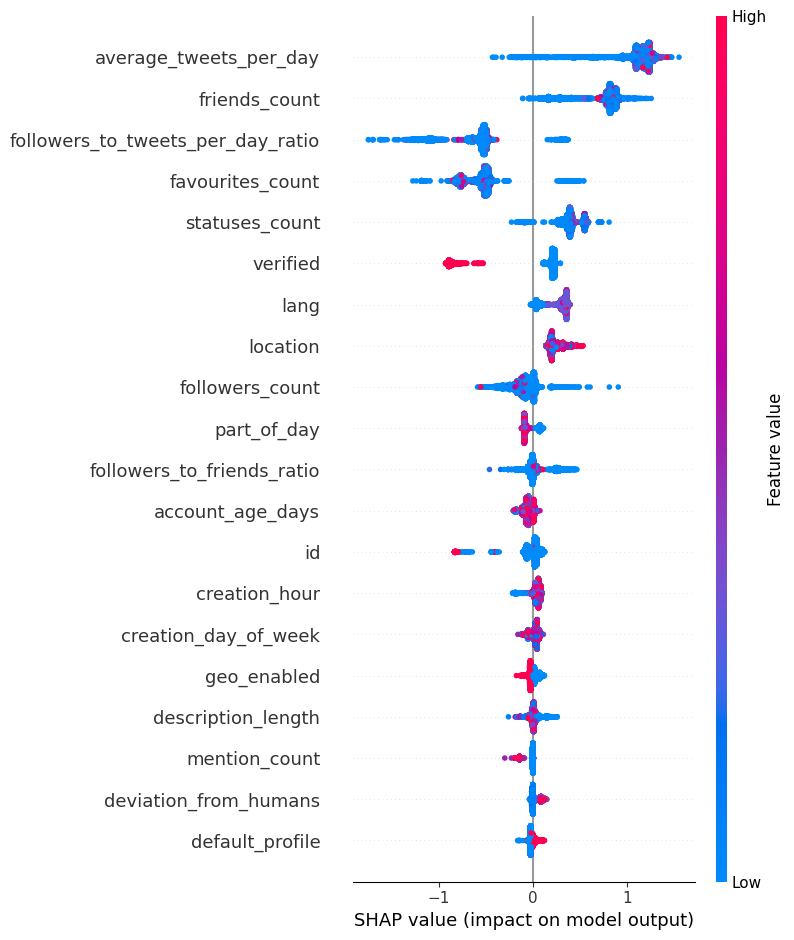

In [171]:
import shap

# Load the model from the pickle file
loaded_model = trainer.load_model('output_files/{0}_best_model.pkl'.format('xgb')) # change model type here

# Assuming you have your data prepared
explainer = shap.Explainer(loaded_model)
test = df[df['X_fold'] == 'test']
X_test = test[features]
y_test = test[target]    
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)


# Local SHAP Explainability

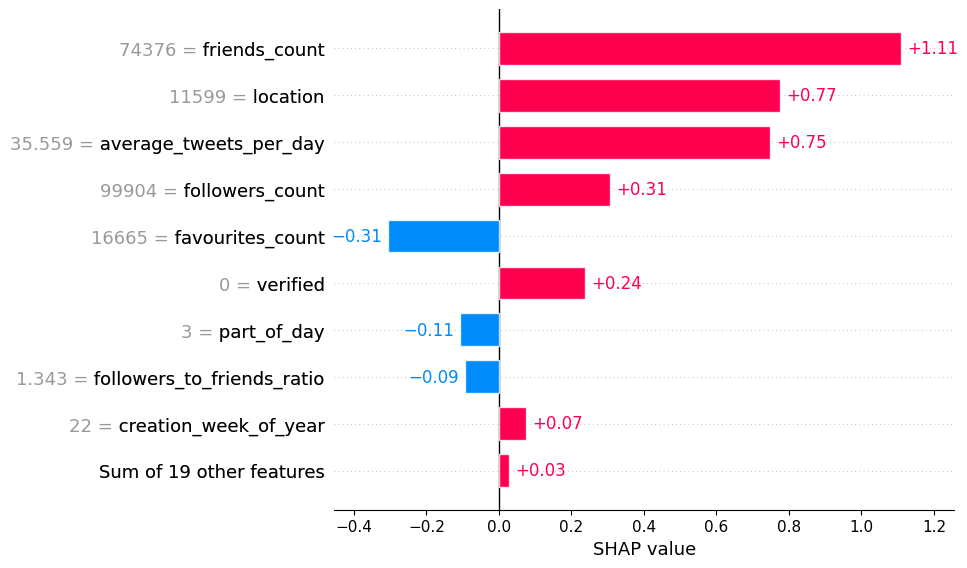

In [87]:
#shap.plots.bar(shap_values)
shap.plots.bar(shap_values[0])


# Auto Encoder

In [96]:
%pip install tensorflow

Python(38179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 239.4 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 24.7 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 396 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 21.7 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.0 MB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 414 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 41.5 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 14.3 MB/s eta 0:00:01
     |█████████████████

In [97]:
# Import necessary libraries for deep learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Filter data for "normal" examples (assuming `account_type` 0 is normal, 1 is anomaly)
normal_data = mds[mds['account_type'] == 0][predictive_cols]
anomalous_data = mds[mds['account_type'] == 1][predictive_cols]

# Scale the data
scaler = StandardScaler()
normal_data_scaled = scaler.fit_transform(normal_data)
anomalous_data_scaled = scaler.transform(anomalous_data)

# Define autoencoder architecture
input_dim = normal_data_scaled.shape[1]  # Number of features
encoding_dim = int(input_dim / 2)  # Define encoding dimension (e.g., half of input)

input_layer = Input(shape=(input_dim,))
# Encoder
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# Decoder
decoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

# Build and compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Train the autoencoder on normal data
history = autoencoder.fit(
    normal_data_scaled, normal_data_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Calculate reconstruction error on normal and anomalous data
normal_data_reconstructed = autoencoder.predict(normal_data_scaled)
anomalous_data_reconstructed = autoencoder.predict(anomalous_data_scaled)

# Compute Mean Squared Error for each sample
normal_mse = np.mean(np.power(normal_data_scaled - normal_data_reconstructed, 2), axis=1)
anomalous_mse = np.mean(np.power(anomalous_data_scaled - anomalous_data_reconstructed, 2), axis=1)

# Define a threshold based on normal data MSE
threshold = np.percentile(normal_mse, 95)  # 95th percentile as threshold

# Flag anomalies based on reconstruction error
normal_data['anomaly'] = normal_mse > threshold
anomalous_data['anomaly'] = anomalous_mse > threshold

# Check anomaly detection performance
print("Anomalies in normal data (false positives):", normal_data['anomaly'].sum())
print("Anomalies in anomalous data (true positives):", anomalous_data['anomaly'].sum())

# Combine results for confusion matrix and performance metrics
# True labels: 0 for normal (account_type 0), 1 for anomalies (account_type 1)
y_true = np.concatenate([np.zeros(len(normal_data)), np.ones(len(anomalous_data))])
# Predicted labels: 1 if flagged as anomaly, 0 otherwise
y_pred = np.concatenate([normal_data['anomaly'].astype(int), anomalous_data['anomaly'].astype(int)])

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate performance metrics
report = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("Classification Report:")
print(report)

# Calculate additional performance metrics (accuracy, precision, recall, F1-score)
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy:.2f}")


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.8310 - val_loss: 0.6620
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.6262 - val_loss: 0.5107
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.4682 - val_loss: 0.4636
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.4094 - val_loss: 0.4397
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.3960 - val_loss: 0.4255
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.3723 - val_loss: 0.4080
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.3841 - val_loss: 0.3992
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.4551 - val_loss: 0.3873
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.3577 - val_loss: 0.3788
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.3963 - val_loss: 0.3723
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.3712 - val_loss: 0.3648
Epoch 12/50
704/704 ━━━━━━━━━━

In [16]:
ae_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count']

# HUNOD
- K-means clustering
- Auto encoder
- Meta learner of Decision tree

Epoch 1/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 0.8462 - val_loss: 0.6133
Epoch 2/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.6062 - val_loss: 0.5775
Epoch 3/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.5756 - val_loss: 0.5534
Epoch 4/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.5517 - val_loss: 0.5417
Epoch 5/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 0.5414 - val_loss: 0.5358
Epoch 6/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 0.5378 - val_loss: 0.5322
Epoch 7/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 0.5326 - val_loss: 0.5296
Epoch 8/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - loss: 0.5292 - val_loss: 0.5277
Epoch 9/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.5264 - val_loss: 0.5260
Epoch 10/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.5211 - val_loss: 0.5246
Epoch 11/50
895/895 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 0.5249 - val_loss: 0.5235
Epoch 12/50
895/895 ━━━━━━━━━━

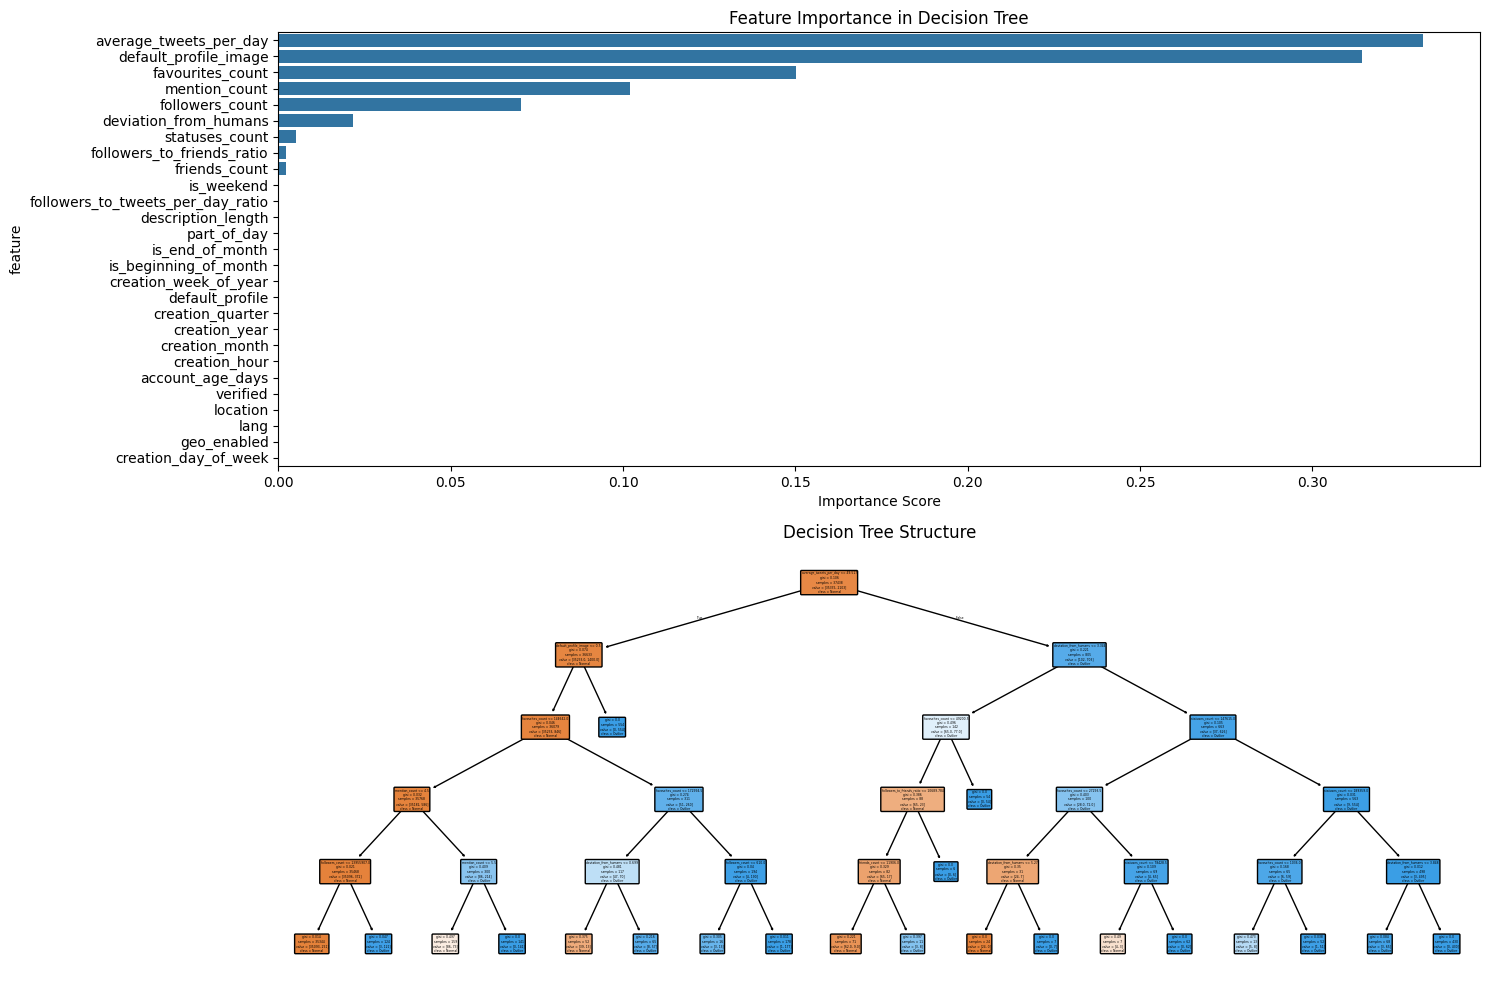


Decision Tree Analysis:

1. Node Statistics:
total_nodes: 41
leaf_nodes: 21
max_depth: 5

2. Feature Threshold Statistics:

average_tweets_per_day:
  mean: 49.52
  min: 49.52
  max: 49.52
  count: 1

default_profile_image:
  mean: 0.50
  min: 0.50
  max: 0.50
  count: 1

favourites_count:
  mean: 79033.30
  min: 1036.00
  max: 172994.50
  count: 5

mention_count:
  mean: 5.00
  min: 4.50
  max: 5.50
  count: 2

followers_count:
  mean: 6978258.50
  min: 610.00
  max: 13955907.00
  count: 2

deviation_from_humans:
  mean: 3.29
  min: 0.70
  max: 5.27
  count: 4

followers_to_friends_ratio:
  mean: 10689.78
  min: 10689.78
  max: 10689.78
  count: 1

friends_count:
  mean: 11906.00
  min: 11906.00
  max: 11906.00
  count: 1

statuses_count:
  mean: 138467.50
  min: 78428.50
  max: 189359.00
  count: 3

3. Decision Rules:
|--- average_tweets_per_day <= 49.52
|   |--- default_profile_image <= 0.50
|   |   |--- favourites_count <= 144642.00
|   |   |   |--- mention_count <= 4.50
|   |   | 

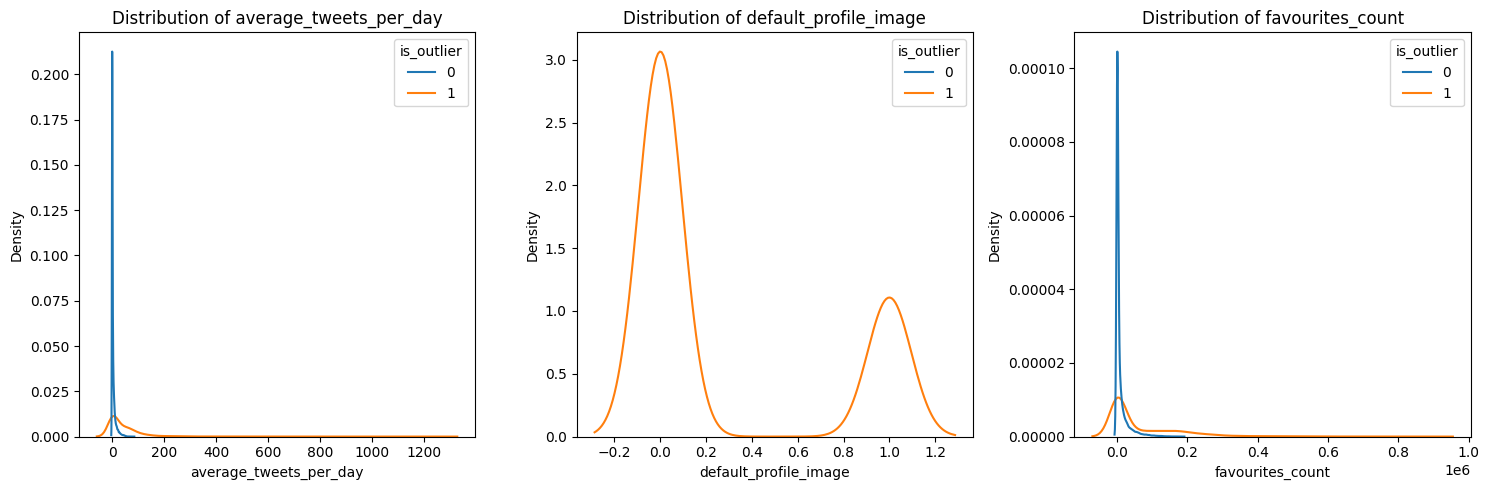

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import shap
import matplotlib.pyplot as plt


X = df[ae_cols].copy()

# Standardize the features for clustering and autoencoder
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use KMeans with a relatively high number of clusters
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust based on your dataset
df['cluster'] = kmeans.fit_predict(X_scaled)

# Calculate outlier scores based on cluster sizes
cluster_sizes = df['cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < (0.05 * len(df))].index  # Adjust the threshold as needed
df['is_cluster_outlier'] = df['cluster'].apply(lambda x: 1 if x in small_clusters else 0)

# Define Autoencoder Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 4  # Size of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on non-outlier data identified by K-means
normal_data = X_scaled[df['is_cluster_outlier'] == 0]
autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Define Autoencoder Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 4  # Size of the encoded representation

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on non-outlier data identified by K-means
normal_data = X_scaled[df['is_cluster_outlier'] == 0]
autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Get reconstruction errors on the entire dataset
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Set a threshold for outlier detection
threshold = np.percentile(reconstruction_errors, 95)  # Adjust as needed
df['is_autoencoder_outlier'] = (reconstruction_errors > threshold).astype(int)

# Final outlier flag
df['is_outlier'] = np.where((df['is_cluster_outlier'] == 1) | (df['is_autoencoder_outlier'] == 1), 1, 0)

# Use the full dataset with the outlier label for the surrogate model
df_surrogate = df.copy()
X_surrogate = df_surrogate[ae_cols]
y_surrogate = df_surrogate['is_outlier']

# Train a Decision Tree on the combined outlier data
surrogate_model = DecisionTreeClassifier(max_depth=5, random_state=42)  # Adjust depth based on interpretability needs
surrogate_model.fit(X_surrogate, y_surrogate)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_decision_tree(model, X, feature_names, output_dict=False):
    """
    Comprehensive analysis of the decision tree model
    """
    # 1. Feature Importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # 2. Get decision rules as text
    tree_rules = export_text(model, feature_names=list(feature_names))
    
    # 3. Calculate feature threshold statistics
    feature_thresholds = {}
    n_nodes = model.tree_.node_count
    features = model.tree_.feature
    thresholds = model.tree_.threshold
    
    for i in range(n_nodes):
        if features[i] != -2:  # Not a leaf node
            feature_name = feature_names[features[i]]
            if feature_name not in feature_thresholds:
                feature_thresholds[feature_name] = []
            feature_thresholds[feature_name].append(thresholds[i])
    
    threshold_stats = {
        feature: {
            'mean': np.mean(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values)
        }
        for feature, values in feature_thresholds.items()
    }
    
    # 4. Get node statistics
    node_stats = {
        'total_nodes': model.tree_.node_count,
        'leaf_nodes': model.get_n_leaves(),
        'max_depth': model.get_depth()
    }
    
    if output_dict:
        return {
            'feature_importance': importance_df,
            'tree_rules': tree_rules,
            'threshold_stats': threshold_stats,
            'node_stats': node_stats
        }
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Feature Importance Plot
    plt.subplot(2, 1, 1)
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Feature Importance in Decision Tree')
    plt.xlabel('Importance Score')
    
    # 2. Decision Tree Visualization
    plt.subplot(2, 1, 2)
    plot_tree(model, feature_names=list(feature_names), 
             class_names=['Normal', 'Outlier'],
             filled=True, rounded=True)
    plt.title('Decision Tree Structure')
    
    plt.tight_layout()
    plt.show()
    
    # Print text-based analysis
    print("\nDecision Tree Analysis:")
    print("=" * 50)
    print("\n1. Node Statistics:")
    for key, value in node_stats.items():
        print(f"{key}: {value}")
    
    print("\n2. Feature Threshold Statistics:")
    for feature, stats in threshold_stats.items():
        if stats['count'] > 0:  # Only show features actually used in the tree
            print(f"\n{feature}:")
            for stat_name, stat_value in stats.items():
                print(f"  {stat_name}: {stat_value:.2f}" if isinstance(stat_value, float) 
                      else f"  {stat_name}: {stat_value}")
    
    print("\n3. Decision Rules:")
    print(tree_rules)

# Analyze the surrogate model
analyze_decision_tree(
    surrogate_model,
    X_surrogate,
    feature_names=ae_cols
)

y_pred = surrogate_model.predict(X_surrogate)
print("\n4. Model Performance:")
print(classification_report(y_surrogate, y_pred))

plt.figure(figsize=(15, 5))
top_features = pd.DataFrame({
    'feature': ae_cols,
    'importance': surrogate_model.feature_importances_
}).nlargest(3, 'importance')['feature']

for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(data=df_surrogate, x=feature, hue='is_outlier', common_norm=False)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


In [24]:
print(classification_report(df['account_type'], y_pred))


              precision    recall  f1-score   support

           0       0.67      0.96      0.79     25013
           1       0.42      0.06      0.11     12425

    accuracy                           0.66     37438
   macro avg       0.55      0.51      0.45     37438
weighted avg       0.59      0.66      0.56     37438

